In [2]:
import numpy as np
import h5py
from osgeo import gdal
import matplotlib.pyplot as plt
import os
from skimage import exposure
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon
import xarray as xr
import rioxarray

from pathlib import Path

def get_map_info(hdf5_file):
    # get the site name
    site_name = str(list(hdf5_file.items())).split("'")[1]
    product_type = str(list(hdf5_file[site_name].items())).split("'")[1] # this is the Reflectance
    base_loc = hdf5_file[site_name][product_type]
    refl_shape = base_loc['Reflectance_Data'].shape
    scale_factor = base_loc['Reflectance_Data'].attrs['Scale_Factor']
    wavelengths = np.array(base_loc['Metadata']['Spectral_Data']['Wavelength'])
    # create a metadata dictionary to store the relevant map information
    metadata = {}
    metadata['wavelengths'] = wavelengths
    metadata['scale_factor'] = scale_factor
    metadata['projection'] = base_loc['Metadata']['Coordinate_System']['Proj4'][()]
    metadata['EPSG'] = int(base_loc['Metadata']['Coordinate_System']['EPSG Code'][()])
    map_info = base_loc['Metadata']['Coordinate_System']['Map_Info'][()]
    map_info_split = str(map_info).split(",")
    # extract the resolution & convert to floating decimal number
    pixel_width = float(map_info_split[5])
    pixel_height = float(map_info_split[6])
    metadata['p_width'] = pixel_width
    metadata['p_height'] = pixel_height
    # extract the upper left-hand corner coordinates from map_info and cast to float
    x_min = float(map_info_split[3]) 
    y_max = float(map_info_split[4])
    # calculate the x_max and yMin values from the dimensions
    x_max = x_min + (refl_shape[1]*pixel_width) #xMax = left edge + (# of columns * x_resolution)\n",
    y_min = y_max - (refl_shape[0]*pixel_height) #yMin = top edge - (# of rows * y_resolution)\n",
    metadata['extent'] = (x_min,x_max,y_min,y_max)
    
    return metadata

def get_bbox(map_info):
    extent = map_info['extent']

    minx = extent[0]
    miny = extent[2]
    maxx = extent[1]
    maxy = extent[3]

    # bottom left, top right, top right, bottom right
    bounding_box = Polygon([Point(minx,miny), Point(minx,maxy), Point(maxx,maxy),Point(maxx,miny),Point(minx,miny)])
    
    return bounding_box

## create stack of red, green, blue channels
def stack_rgb(refl_array,bands):
    red = refl_array[:,:,bands[0]-1]
    green = refl_array[:,:,bands[1]-1]
    blue = refl_array[:,:,bands[2]-1]
    stacked_rgb = np.stack((red,green,blue),axis=2)
    rescaled_rgb = ((stacked_rgb - stacked_rgb.min()) * (1/(stacked_rgb.max() - stacked_rgb.min()) * 255)).astype('uint8')
    return rescaled_rgb

### adjust brightness and plot image
def plot_refl_rgb(rgb_array,ext,ls_pct=5,plot_title=''):   
    p_low, p_high = np.percentile(rgb_array[~np.isnan(rgb_array)], (ls_pct,100-ls_pct))
    img_rescale = exposure.rescale_intensity(rgb_array, in_range=(p_low,p_high))
    
    plt.imshow(img_rescale,extent=ext)
    plt.title(plot_title); 
    ax = plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) 

# refl_rgb = stack_rgb(ref_data,(58,34,19))
# plot_refl_rgb(refl_rgb,ext=map_info['extent'],ls_pct=.1,plot_title="Reflectance RGB Image")

def get_ref_data(index):
    
    h5_file = h5py.File(ref_data_path / os.listdir(ref_data_path)[index])
    site_name = str(list(h5_file.items())).split("'")[1]
    ref_data = h5_file[site_name]['Reflectance']['Reflectance_Data']

    map_info = get_map_info(h5_file)
    bbox = get_bbox(map_info)

    return ref_data, map_info, bbox

def make_spatial_array(ref_data,map_info):

    xds = xr.DataArray(ref_data[:,:,:])
    xds.rio.write_crs(32618,inplace=True)
    xds = xds.rename({"dim_1": "x", "dim_0": "y","dim_2":"bands"})

    xds.rio.set_spatial_dims(
        x_dim="x",
        y_dim="y",
        inplace=True,
    ).rio.write_coordinate_system(inplace=True)

    xds.coords['x'] = np.arange(map_info['extent'][0],map_info['extent'][1],map_info['p_width'])
    xds.coords['y'] = np.arange(map_info['extent'][2],map_info['extent'][3],map_info['p_height'])
    # apply scaling factor to reflectance values
    xds = xds/map_info['scale_factor']

    return xds

def get_values_for_tile_pixels(xds,bbox, map_info):

    tile_gdf = trees_gdf[trees_gdf.geometry.intersects(bbox,align=True)]
    tile_gdf = tile_gdf.reset_index()
    cc = tile_gdf.get_coordinates()
    cc = cc.reset_index().drop('index',axis=1)

    pixel_df = pd.DataFrame()
    
    if len(tile_gdf) > 0:
        for i,row in tile_gdf.iterrows():
            value = xds.sel(x=cc.iloc[i,0], y=cc.iloc[i,1], method="nearest").values
            df = pd.DataFrame(data=np.reshape(value,(1,426)),columns=map_info['wavelengths'])
            df['taxonID'] = tile_gdf.loc[i,'taxonID']
            df['individualID'] = tile_gdf.loc[i,'individualID']
            pixel_df = pd.concat([pixel_df,df])

    
    return pixel_df
    







# set path variables
root = Path.cwd()
site = '2019_BART_5' #'2019_HARV_6'
ref_data_path = root / 'DP3.30006.001' / 'neon-aop-products' / '2019' / 'FullSite' / 'D01' / site / 'L3' / 'Spectrometer' / 'Reflectance'

# read in tree location data
# site_folder = 'HARV'
# trees_df = pd.read_csv(root / site_folder / f'neon_trees_{site_folder}.csv')
# if site_folder == 'BART':
#     trees_df.taxonID = trees_df.taxonID.replace(to_replace='BEPA',value='BEPAP')
# trees_df.taxonID.value_counts()
# geometry = gpd.points_from_xy(trees_df.easting_tree, trees_df.northing_tree, crs="EPSG:32618")
# trees_df['geometry'] = geometry
# trees_gdf = gpd.GeoDataFrame(trees_df,geometry='geometry',crs='EPSG:32618')


In [3]:
ref_data, map_info, bbox = get_ref_data(0)

In [4]:
ref_data

<HDF5 dataset "Reflectance_Data": shape (1000, 1000, 426), type "<i2">

In [ ]:
# for each  tile, identify the tree points located in it, and extract wavelengths to dataframe

# create dataframe to hold spectral signatures
final_df = pd.DataFrame()

for i in range(0,len(os.listdir(ref_data_path))):
    print(i)
    # define reflectance data, spatial metadata, and bounding polygon
    ref_data, map_info, bbox = get_ref_data(i)
    # add spatial coordinates to reflectance data and apply scaling factor
    xds = make_spatial_array(ref_data, map_info)
   # identify points intersecting bounding polygon and extract spectral signature
    tile_df = get_values_for_tile_pixels(xds,bbox,map_info)
   
    print(i, len(tile_df))
    # if any points were present in the tile, add to final dataframe
    if len(tile_df) > 0:
        final_df = pd.concat([final_df,tile_df])

final_df = final_df.reset_index().drop('index',axis=1)
# write results to disk
final_df.to_csv('tree_spectral_sigs.csv')

In [15]:
# read in saved csv and remove unnecessary column

df = pd.read_csv(root / site_folder / f'tree_spectral_sigs_{site_folder}.csv')
df = df.iloc[:,1:]

In [16]:
# count number of samples in each species
grouped_df = df.groupby('taxonID')

species = []
counts = []
for group in grouped_df:
    species.append(group[0])
    counts.append(len(group[1]))

counts_df = pd.DataFrame({'species': species, 'counts': counts})

# filter out species with fewer than 10 samples
gt_10_samples = counts_df[counts_df.counts >=10]
top_species = list(gt_10_samples.species)
df_top_species = df.loc[df.taxonID.isin(top_species)]

# calculate mean wavelengths for each species
means_df = df_top_species.iloc[:,:-1].groupby('taxonID').agg('mean')
means_df_transpose = means_df.T.reset_index().rename(columns={'index':'wavelength'})
means_df_transpose['wavelength'] = means_df_transpose['wavelength'].astype('float')

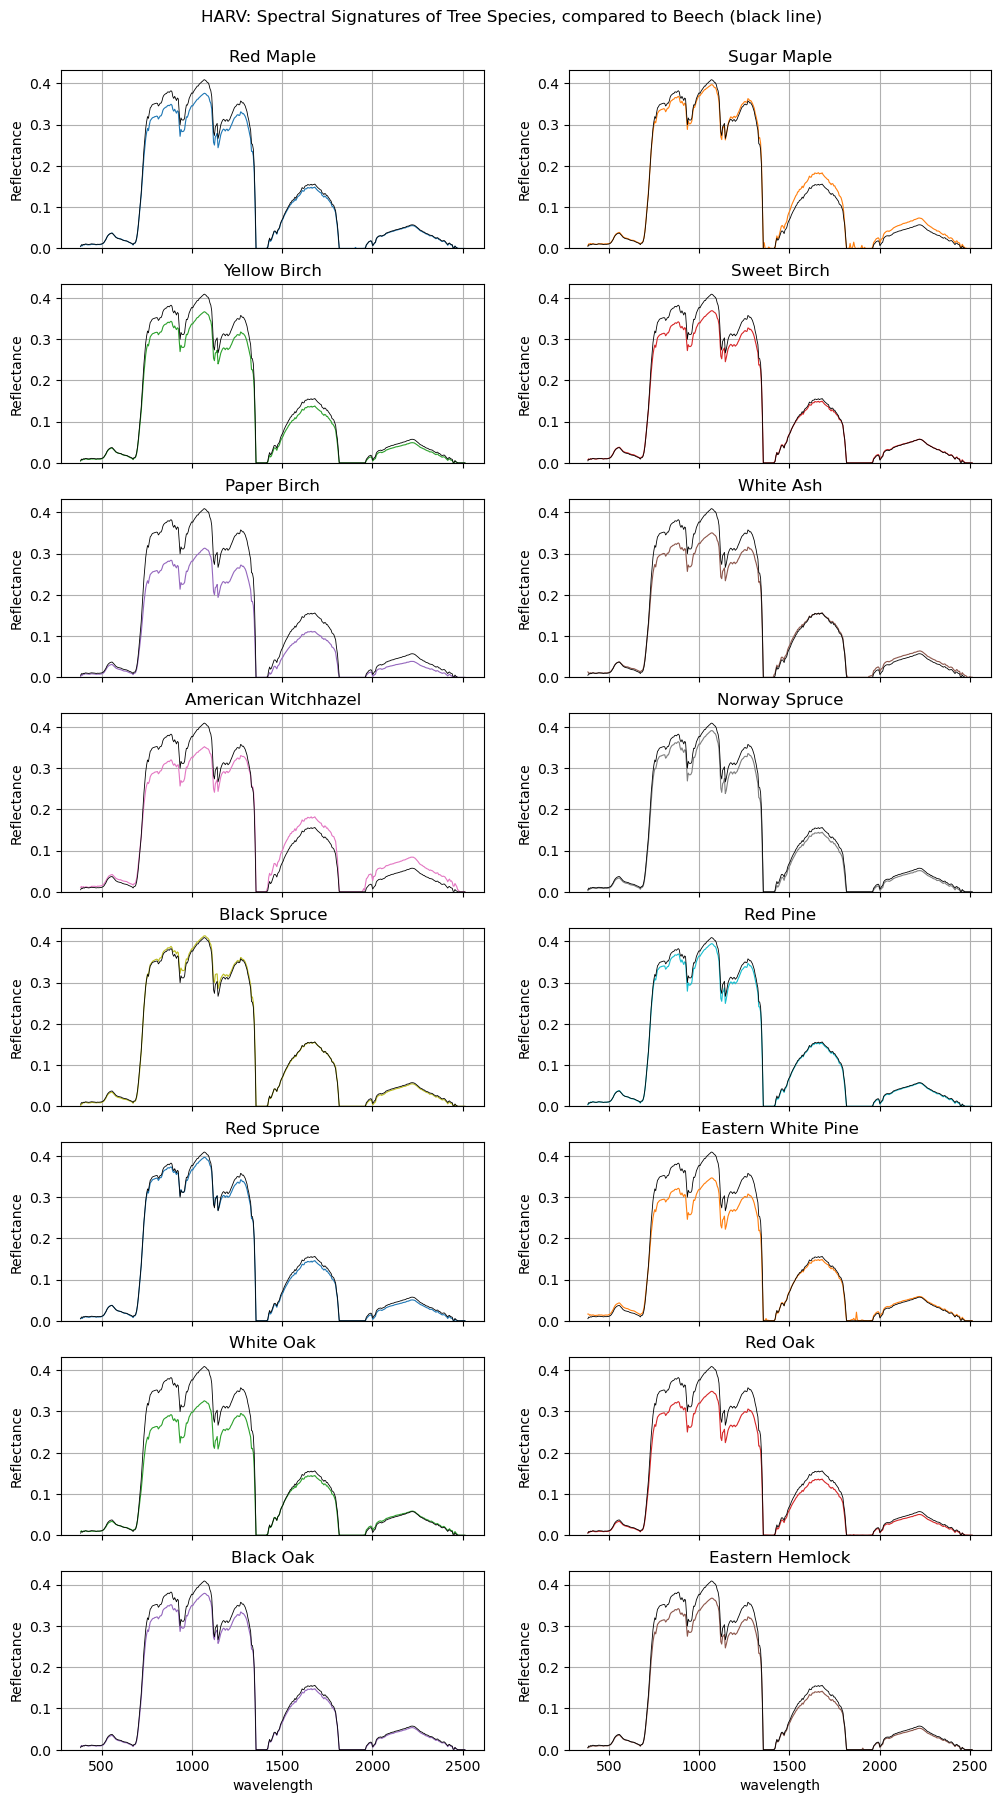

In [17]:
# remove beech from column names
if 'FAGR' in top_species:
    top_species.remove('FAGR')
# remove beech column from df
means_df_plot = means_df_transpose.drop('FAGR',axis=1)
# set plot titles
if site_folder == 'HARV':
    tree_names = ['Red Maple', 'Sugar Maple', 'Yellow Birch', 'Sweet Birch', 'Paper Birch', 'White Ash', 'American Witchhazel', 'Norway Spruce','Black Spruce','Red Pine','Red Spruce','Eastern White Pine', 'White Oak', 'Red Oak','Black Oak', 'Eastern Hemlock']
if site_folder == 'BART':
    tree_names = ['Striped Maple', 'Red Maple', 'Sugar Maple', 'Yellow Birch', 'Paper Birch', 'White Ash', 'Red Spruce', 'Eastern Hemlock']
# plot each species on different subplot
max_wl = np.round(means_df_plot.iloc[:,1:].max().max(),4) + 0.02
ax = means_df_plot.plot(figsize=(12,20),subplots=True, x='wavelength', layout=(8,2),ylim=[0,max_wl], title=tree_names, ylabel='Reflectance',legend=False,lw=.8,grid=True)
plt.subplots_adjust(top=.95)
plt.suptitle(f'{site_folder}: Spectral Signatures of Tree Species, compared to Beech (black line)')
# overlay beech spectral signature on each plot
for ax_row in ax:
    for axis in ax_row:
        axis.plot(means_df_transpose.wavelength, means_df_transpose['FAGR'],color='black',lw=.6)

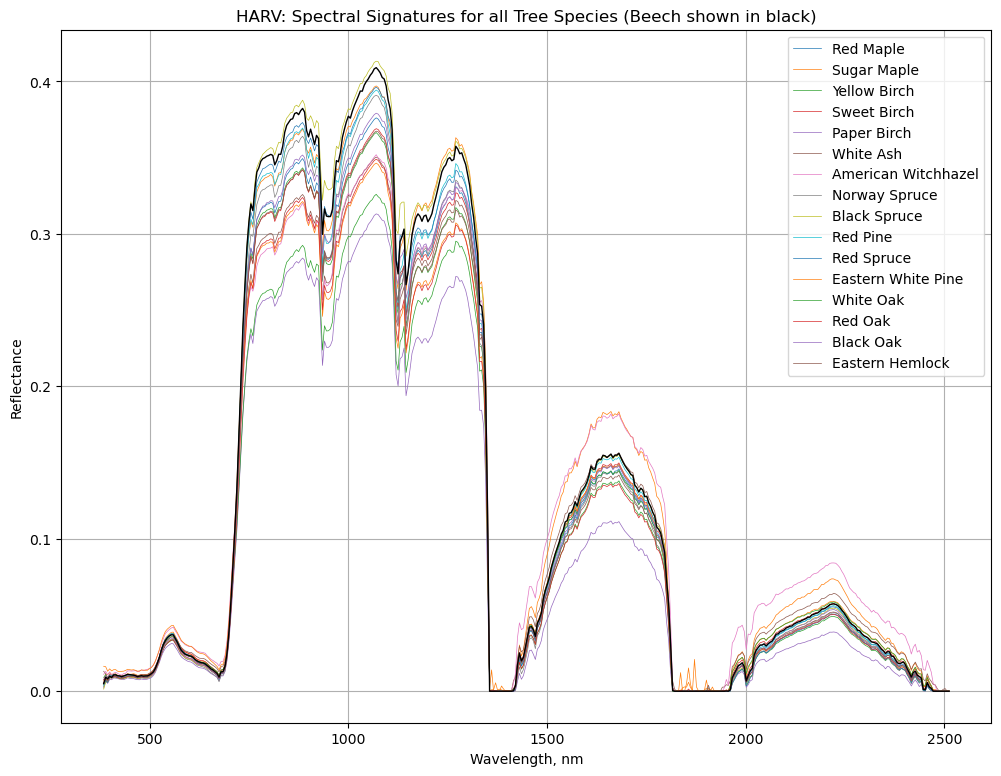

In [18]:
# plot all non-beech spectral signatures
means_df_transpose.plot(figsize=(12,9),x='wavelength',y=top_species,kind='line',lw=.5)
plt.title(f'{site_folder}: Spectral Signatures for all Tree Species (Beech shown in black)')
ax = plt.gca() 
# overlay beech spectral signature
ax.plot(means_df_transpose.wavelength, means_df_transpose['FAGR'],color='black',lw=1)
# add legend labels
plt.legend(tree_names)
# format plot
#ax.set_yticks(np.arange(0,0.5,0.05))
ax.set_xlabel("Wavelength, nm")
ax.set_ylabel("Reflectance")
ax.grid('on')

In [ ]:
# exploratory analysis: loop through tiles and get bounding boxes 

#file_list = list()
# bbox_series = gpd.GeoSeries(data=[],crs='32618')

# for f in os.listdir(ref_data_path):
    
#     h5_file = h5py.File(ref_data_path / f)

#     ref_data = h5_file['HARV']['Reflectance']['Reflectance_Data']
#     #print(ref_data.attrs['Scale_Factor'], ref_data.attrs['Data_Ignore_Value'])
#     spatial_info = get_map_info(h5_file)

#     extent_geo = get_bbox(spatial_info)
  
#     bbox_series = pd.concat([bbox_series,extent_geo.geometry])
       
    
# # plot tiles and tree points to see overlap
# ax = bbox_series.plot(color='green')
# trees_gdf.plot(ax=ax, color='red')
